<a href="https://colab.research.google.com/github/ddeMoivre/Deep-learning/blob/master/Image_Classifiacation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><h1>Pre-trained Models with PyTorch </h1>


In the context of AI Capstone Project with Deep Learning, part of the IBM AI Engineering Professional Certificate, we will use pre-trained models to classify between the negative and positive samples. Crack detection has vital importance for structural health monitoring and inspection. We would like to train a network to detect Cracks, we will denote the images that contain cracks as positive and images with no cracks as negative. The particular pre-trained model will be resnet18; we answer to three questions:

<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>


<h2>Table of Contents</h2>


<ul>
    <li><a href="https://#download_data"> Download Data</a></li>
    <li><a href="https://#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="https://#data_class"> Dataset Class</a></li>
    <li><a href="https://#Question_1">Question 1</a></li>
    <li><a href="https://#Question_2">Question 2</a></li>
    <li><a href="https://#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

In [2]:
#!unzip -q Positive_tensors.zip

In [3]:
#! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
#!unzip -q Negative_tensors.zip

We will install torchvision:


In [4]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [7]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


In [8]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content/drive/MyDrive/IBM/Data"
        positive="Positive"
        negative='Negative'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):

        image=Image.open(self.all_files[idx])
        y=self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
                  
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

composed = transforms.Compose([transforms.Resize(224), 
                               transforms.ToTensor(), 
                               transforms.Normalize(mean,std)])

train_dataset = Dataset(transform=composed, train=True)
validation_dataset = Dataset(transform=composed, train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [10]:
# Step 1: Load the pre-trained model resnet18

model = models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
    param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [12]:
model.fc=nn.Linear(512,2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function


In [14]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [16]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [17]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
  for i, (x, y) in enumerate(train_loader):
       
    # set model to train 
    model.train() 
        
    # clear gradient 
    optimizer.zero_grad()
     
    # make a prediction 
    z = model(x)
   
    # calculate loss 
    loss = criterion(z, y) 
    # loss.requires_grad = True
    
    # calculate gradients of parameters 
    loss.backward()
        
    # update parameters 
    optimizer.step()
        
    loss_list.append(loss.data)
    if i%10==0:
      print("Finished in {}th batch (s)".format(i))
    # end for
        
  correct=0
  for i, (x_test, y_test) in enumerate(validation_loader):
 
    # set model to eval 
    model.eval()
       
    # make a prediction 
    z = model(x_test)
        
    # find max 
    _, yhat = torch.max(z.data, 1)
       
    #Calculate misclassified  samples in mini-batch 
    #hint +=(yhat==y_test).sum().item()
    correct += (yhat==y_test).sum().item()  
        
    if i%10==0:
      print("Finished in {}th batch".format(i))
    # end for
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("-" * 72)
    
# end for

Finished in 0th batch (s)
Finished in 10th batch (s)
Finished in 20th batch (s)
Finished in 30th batch (s)
Finished in 40th batch (s)
Finished in 50th batch (s)
Finished in 60th batch (s)
Finished in 70th batch (s)
Finished in 80th batch (s)
Finished in 90th batch (s)
Finished in 100th batch (s)
Finished in 110th batch (s)
Finished in 120th batch (s)
Finished in 130th batch (s)
Finished in 140th batch (s)
Finished in 150th batch (s)
Finished in 160th batch (s)
Finished in 170th batch (s)
Finished in 180th batch (s)
Finished in 190th batch (s)
Finished in 200th batch (s)
Finished in 210th batch (s)
Finished in 220th batch (s)
Finished in 230th batch (s)
Finished in 240th batch (s)
Finished in 250th batch (s)
Finished in 260th batch (s)
Finished in 270th batch (s)
Finished in 280th batch (s)
Finished in 290th batch (s)
Finished in 0th batch
Epoch 1 - accuracy: 0.010
------------------------------------------------------------------------
Epoch 1 - accuracy: 0.020
------------------------

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [18]:
accuracy

0.9942

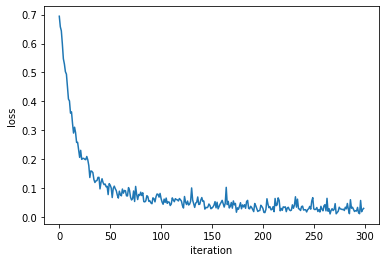

In [19]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


Sample : 388; y: 1; yhat: 0


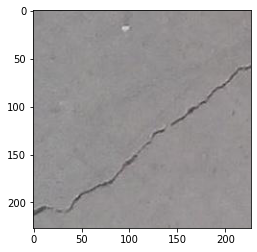

Sample : 442; y: 1; yhat: 0


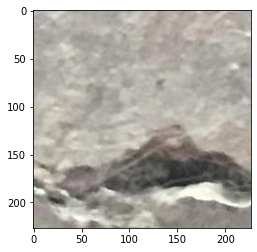

Sample : 556; y: 1; yhat: 0


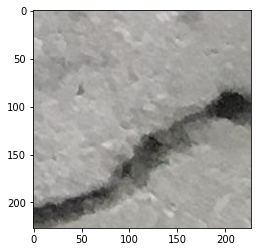

Sample : 573; y: 0; yhat: 1


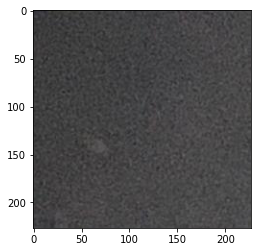

In [20]:
validation_loader_batch_one = DataLoader(dataset=validation_dataset, batch_size=1)
count = 0
for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
  model.eval()
  z = model(x_test)
  _, yhat = torch.max(z.data, 1)
  if yhat != y_test:
    plt.imshow(Dataset(train=False)[i][0])
    print("Sample : {}; y: {}; yhat: {}".format(str(i), str(y_test.item()), str(yhat.item())))
    plt.show()
    count += 1
  if count >= 4:
        break     